In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures, scale
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import datetime
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('600K US Housing Properties.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   property_url        600000 non-null  object 
 1   property_id         600000 non-null  int64  
 2   address             600000 non-null  object 
 3   street_name         599869 non-null  object 
 4   apartment           14815 non-null   object 
 5   city                599999 non-null  object 
 6   state               599999 non-null  object 
 7   latitude            529122 non-null  float64
 8   longitude           529122 non-null  float64
 9   postcode            599970 non-null  object 
 10  price               600000 non-null  float64
 11  bedroom_number      443845 non-null  float64
 12  bathroom_number     471733 non-null  float64
 13  price_per_unit      435365 non-null  float64
 14  living_space        447847 non-null  float64
 15  land_space          515119 non-nul

In [4]:
description = df.describe(include='all')
description

,property_url,property_id,address,street_name,apartment,city,state,latitude,longitude,postcode,...,property_type,property_status,year_build,total_num_units,listing_age,RunDate,agency_name,agent_name,agent_phone,is_owned_by_zillow
count,600000,6.000000e+05,600000,599869,14815,599999,599999,529122.000000,529122.000000,599970,...,600000,600000,0.0,0.0,600000.0,600000,444524,0.0,0.0,600000.000000
unique,600000,NaN,598588,339224,2664,7977,25,NaN,NaN,10820,...,7,2,NaN,NaN,NaN,1,34372,NaN,NaN,NaN
top,https://www.zillow.com/homedetails/3-Plat-83-1...,NaN,"(undisclosed Address), Rockport, TX 78382",(undisclosed Address),1,Chicago,TX,NaN,NaN,84043,...,SINGLE_FAMILY,FOR_SALE,NaN,NaN,NaN,2022-04-24 07:34:15,Coldwell Banker Realty,NaN,NaN,NaN
freq,1,NaN,36,1713,312,14138,146636,NaN,NaN,1102,...,354366,383365,NaN,NaN,NaN,600000,5936,NaN,NaN,NaN
mean,NaN,8.885042e+08,NaN,NaN,NaN,NaN,NaN,36.282379,-105.813906,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000498
std,NaN,9.724708e+08,NaN,NaN,NaN,NaN,NaN,5.673355,13.464633,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.022318
min,NaN,2.700000e+01,NaN,NaN,NaN,NaN,NaN,18.985142,-165.408250,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000
25%,NaN,5.402143e+07,NaN,NaN,NaN,NaN,NaN,32.612112,-117.346079,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000
50%,NaN,2.066090e+08,NaN,NaN,NaN,NaN,NaN,35.403568,-101.897378,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000
75%,NaN,2.066867e+09,NaN,NaN,NaN,NaN,NaN,39.661674,-95.354245,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000


In [5]:
df.columns

Index(['property_url', 'property_id', 'address', 'street_name', 'apartment',
       'city', 'state', 'latitude', 'longitude', 'postcode', 'price',
       'bedroom_number', 'bathroom_number', 'price_per_unit', 'living_space',
       'land_space', 'land_space_unit', 'broker_id', 'property_type',
       'property_status', 'year_build', 'total_num_units', 'listing_age',
       'RunDate', 'agency_name', 'agent_name', 'agent_phone',
       'is_owned_by_zillow'],
      dtype='object')

In [6]:
df = df.drop(df[df.living_space == 0].index)
df = df.drop(df[df.price == 0].index)
df['longitude'] = -df['longitude']
#Selected just the Texas data to reduce column number so model can fit and predict
df = df[df.state == 'TX']

In [7]:
#Land space is an important metric for the price of the house but this dataset has multiple units
#All the values with 'acres' unit changed to 'sqft'
df.loc[df['land_space_unit']=='acres', 'land_space'] = df['land_space']*43560.00
df.loc[df['land_space_unit']=='acres', 'land_space_unit']='sqft'
df[['land_space','land_space_unit']]

,land_space,land_space_unit
180271,6969.600,sqft
180273,12632.400,sqft
180275,11325.600,sqft
180277,15246.000,sqft
180279,6000.000,sqft
...,...,...
446346,8145.720,sqft
446348,3920.400,sqft
446350,4356.000,sqft
446352,4299.372,sqft


In [8]:
df = df.drop(columns=['property_url', 'property_id', 'address', 'street_name', 'apartment', 'city', 'state', 'price_per_unit', 'land_space_unit', 'broker_id','property_status', 'year_build', 'total_num_units', 'listing_age',
       'RunDate', 'agency_name', 'agent_name', 'agent_phone',
       'is_owned_by_zillow'])

In [9]:
df_isna=df.isna()
df_isna

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type
180271,False,False,False,False,False,False,False,False,False
180273,False,False,False,False,False,False,False,False,False
180275,False,False,False,False,False,False,False,False,False
180277,False,False,False,False,False,False,False,False,False
180279,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...
446346,False,False,False,False,False,False,False,False,False
446348,False,False,False,False,False,False,False,False,False
446350,False,False,False,False,False,False,False,False,False
446352,False,False,False,False,False,False,False,False,False


In [10]:
df_isna.columns=[c for c in df_isna.columns]
df_isna

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type
180271,False,False,False,False,False,False,False,False,False
180273,False,False,False,False,False,False,False,False,False
180275,False,False,False,False,False,False,False,False,False
180277,False,False,False,False,False,False,False,False,False
180279,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...
446346,False,False,False,False,False,False,False,False,False
446348,False,False,False,False,False,False,False,False,False
446350,False,False,False,False,False,False,False,False,False
446352,False,False,False,False,False,False,False,False,False


In [11]:
df_isna.columns=[c+'_isna' for c in df_isna.columns]
df_isna

,latitude_isna,longitude_isna,postcode_isna,price_isna,bedroom_number_isna,bathroom_number_isna,living_space_isna,land_space_isna,property_type_isna
180271,False,False,False,False,False,False,False,False,False
180273,False,False,False,False,False,False,False,False,False
180275,False,False,False,False,False,False,False,False,False
180277,False,False,False,False,False,False,False,False,False
180279,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...
446346,False,False,False,False,False,False,False,False,False
446348,False,False,False,False,False,False,False,False,False
446350,False,False,False,False,False,False,False,False,False
446352,False,False,False,False,False,False,False,False,False


In [12]:
df=pd.concat([df.fillna(0), df_isna.astype(float)], axis=1)
df

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type,latitude_isna,longitude_isna,postcode_isna,price_isna,bedroom_number_isna,bathroom_number_isna,living_space_isna,land_space_isna,property_type_isna
180271,31.786737,106.428020,79903,239500.0,5.0,3.0,1692.0,6969.600,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180273,31.784021,106.404450,79925,165000.0,4.0,2.0,1650.0,12632.400,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180275,31.761911,106.432330,79905,118000.0,4.0,1.0,1918.0,11325.600,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180277,31.790165,106.435960,79903,414700.0,4.0,3.0,3119.0,15246.000,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180279,31.775480,106.438230,79905,260000.0,0.0,0.0,3267.0,6000.000,MULTI_FAMILY,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,96.710945,75023,393000.0,3.0,2.0,1717.0,8145.720,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446348,33.044098,96.707720,75023,315000.0,3.0,3.0,1754.0,3920.400,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446350,33.069946,96.712920,75023,360000.0,4.0,3.0,2068.0,4356.000,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446352,33.070004,96.713900,75023,447000.0,4.0,3.0,2111.0,4299.372,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
description = df.describe(include='all')
description

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type,latitude_isna,longitude_isna,postcode_isna,price_isna,bedroom_number_isna,bathroom_number_isna,living_space_isna,land_space_isna,property_type_isna
count,145843.000000,145843.000000,145843,1.458430e+05,145843.000000,145843.000000,1.458430e+05,1.458430e+05,145843,145843.000000,145843.000000,145843.0,145843.0,145843.000000,145843.000000,145843.000000,145843.000000,145843.0
unique,NaN,NaN,1752,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,75126,NaN,NaN,NaN,NaN,NaN,SINGLE_FAMILY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,981,NaN,NaN,NaN,NaN,NaN,101682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,26.692301,84.079336,NaN,4.934353e+05,2.616101,2.070934,2.676817e+03,6.505004e+05,NaN,0.133911,0.133911,0.0,0.0,0.227196,0.134371,0.233573,0.155633,0.0
std,10.620740,33.111143,NaN,1.029319e+06,1.719593,1.537674,7.068093e+04,6.031445e+07,NaN,0.340558,0.340558,0.0,0.0,0.419022,0.341051,0.423105,0.362508,0.0
min,0.000000,0.000000,NaN,1.000000e+00,0.000000,0.000000,0.000000e+00,-1.089000e+04,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,29.441916,95.300135,NaN,2.105000e+05,1.000000,1.000000,8.580000e+02,5.227200e+03,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,30.080057,96.580570,NaN,3.480000e+05,3.000000,2.000000,1.769000e+03,8.485488e+03,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
75%,32.312263,97.814040,NaN,5.249000e+05,4.000000,3.000000,2.480000e+03,3.158100e+04,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [14]:
df.isna().sum()

latitude                0
longitude               0
postcode                0
price                   0
bedroom_number          0
bathroom_number         0
living_space            0
land_space              0
property_type           0
latitude_isna           0
longitude_isna          0
postcode_isna           0
price_isna              0
bedroom_number_isna     0
bathroom_number_isna    0
living_space_isna       0
land_space_isna         0
property_type_isna      0
dtype: int64

In [15]:
df.head()

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type,latitude_isna,longitude_isna,postcode_isna,price_isna,bedroom_number_isna,bathroom_number_isna,living_space_isna,land_space_isna,property_type_isna
180271,31.786737,106.42802,79903,239500.0,5.0,3.0,1692.0,6969.6,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180273,31.784021,106.40445,79925,165000.0,4.0,2.0,1650.0,12632.4,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180275,31.761911,106.43233,79905,118000.0,4.0,1.0,1918.0,11325.6,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180277,31.790165,106.43596,79903,414700.0,4.0,3.0,3119.0,15246.0,SINGLE_FAMILY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180279,31.775480,106.43823,79905,260000.0,0.0,0.0,3267.0,6000.0,MULTI_FAMILY,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [16]:
# A crucial categorical feature 'property_type' is categorical variable so I wanted to transform that to a numeric one
dummies=pd.get_dummies(df[['postcode','property_type']], drop_first=True)
dummies

,postcode_11111,postcode_73870,postcode_75001,postcode_75002,postcode_75006,postcode_75007,postcode_75009,postcode_75010,postcode_75013,postcode_75017,...,postcode_79936,postcode_79938,postcode_79968,postcode_97316,property_type_CONDO,property_type_LOT,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
df = pd.concat([df,dummies],axis='columns')
df

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type,latitude_isna,...,postcode_79936,postcode_79938,postcode_79968,postcode_97316,property_type_CONDO,property_type_LOT,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,31.786737,106.428020,79903,239500.0,5.0,3.0,1692.0,6969.600,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
180273,31.784021,106.404450,79925,165000.0,4.0,2.0,1650.0,12632.400,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
180275,31.761911,106.432330,79905,118000.0,4.0,1.0,1918.0,11325.600,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
180277,31.790165,106.435960,79903,414700.0,4.0,3.0,3119.0,15246.000,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
180279,31.775480,106.438230,79905,260000.0,0.0,0.0,3267.0,6000.000,MULTI_FAMILY,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,96.710945,75023,393000.0,3.0,2.0,1717.0,8145.720,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
446348,33.044098,96.707720,75023,315000.0,3.0,3.0,1754.0,3920.400,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
446350,33.069946,96.712920,75023,360000.0,4.0,3.0,2068.0,4356.000,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0
446352,33.070004,96.713900,75023,447000.0,4.0,3.0,2111.0,4299.372,SINGLE_FAMILY,0.0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
df = df.drop(columns=['postcode','property_type'])
df

,latitude,longitude,price,bedroom_number,bathroom_number,living_space,land_space,latitude_isna,longitude_isna,postcode_isna,...,postcode_79936,postcode_79938,postcode_79968,postcode_97316,property_type_CONDO,property_type_LOT,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,31.786737,106.428020,239500.0,5.0,3.0,1692.0,6969.600,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180273,31.784021,106.404450,165000.0,4.0,2.0,1650.0,12632.400,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180275,31.761911,106.432330,118000.0,4.0,1.0,1918.0,11325.600,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180277,31.790165,106.435960,414700.0,4.0,3.0,3119.0,15246.000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180279,31.775480,106.438230,260000.0,0.0,0.0,3267.0,6000.000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,96.710945,393000.0,3.0,2.0,1717.0,8145.720,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
446348,33.044098,96.707720,315000.0,3.0,3.0,1754.0,3920.400,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
446350,33.069946,96.712920,360000.0,4.0,3.0,2068.0,4356.000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
446352,33.070004,96.713900,447000.0,4.0,3.0,2111.0,4299.372,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
df.dtypes

latitude                       float64
longitude                      float64
price                          float64
bedroom_number                 float64
bathroom_number                float64
                                ...   
property_type_LOT                uint8
property_type_MANUFACTURED       uint8
property_type_MULTI_FAMILY       uint8
property_type_SINGLE_FAMILY      uint8
property_type_TOWNHOUSE          uint8
Length: 1773, dtype: object

In [20]:
df["price_per_sqfoot"] = df["price"] / df["living_space"]

In [21]:
q_low = df["bedroom_number"].quantile(0.01)
q_hi  = df["bedroom_number"].quantile(0.99)

df = df[(df["bedroom_number"] < q_hi) & (df["bedroom_number"] > q_low)]

In [22]:
q_low = df["bathroom_number"].quantile(0.01)
q_hi  = df["bathroom_number"].quantile(0.99)

df = df[(df["bathroom_number"] < q_hi) & (df["bathroom_number"] > q_low)]

In [23]:
q_low = df["living_space"].quantile(0.01)
q_hi  = df["living_space"].quantile(0.99)

df = df[(df["living_space"] < q_hi) & (df["living_space"] > q_low)]

In [24]:
q_low = df["land_space"].quantile(0.01)
q_hi  = df["land_space"].quantile(0.99)

df = df[(df["land_space"] < q_hi) & (df["land_space"] > q_low)]

In [25]:
q_low = df["price"].quantile(0.01)
q_hi  = df["price"].quantile(0.99)

df = df[(df["price"] < q_hi) & (df["price"] > q_low)]

In [26]:
q_low = df["price_per_sqfoot"].quantile(0.01)
q_hi  = df["price_per_sqfoot"].quantile(0.99)

df = df[(df["price_per_sqfoot"] < q_hi) & (df["price_per_sqfoot"] > q_low)]

In [27]:
description = df.describe(include='all')
description

,latitude,longitude,price,bedroom_number,bathroom_number,living_space,land_space,latitude_isna,longitude_isna,postcode_isna,...,postcode_79938,postcode_79968,postcode_97316,property_type_CONDO,property_type_LOT,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE,price_per_sqfoot
count,66105.000000,66105.000000,6.610500e+04,66105.000000,66105.000000,66105.000000,6.610500e+04,66105.000000,66105.000000,66105.0,...,66105.000000,66105.0,66105.000000,66105.000000,66105.000000,66105.000000,66105.000000,66105.000000,66105.000000,66105.000000
mean,27.632022,87.077430,4.069232e+05,3.372165,2.607420,2091.147054,2.926631e+04,0.103608,0.103608,0.0,...,0.002405,0.0,0.000015,0.019545,0.000166,0.025807,0.004780,0.914182,0.035383,194.195588
std,9.532899,29.661268,1.930118e+05,0.587137,0.692579,630.602613,8.760787e+04,0.304754,0.304754,0.0,...,0.048985,0.0,0.003889,0.138430,0.012899,0.158562,0.068975,0.280097,0.184748,66.850146
min,0.000000,0.000000,9.850000e+04,1.000000,1.500000,946.000000,3.850000e-02,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.601671
25%,29.521435,95.414580,2.749000e+05,3.000000,2.000000,1615.000000,5.989500e+03,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,149.617258
50%,30.102903,96.784160,3.620000e+05,3.000000,2.000000,1993.000000,7.797240e+03,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,182.500000
75%,32.444790,97.827250,4.950000e+05,4.000000,3.000000,2487.000000,1.228392e+04,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,223.564307
max,36.461475,106.624420,1.449000e+06,4.000000,4.000000,4145.000000,1.038035e+06,1.000000,1.000000,0.0,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,499.990654


In [28]:
features=df.describe().columns.drop(['price', 'price_per_sqfoot'])
features

Index(['latitude', 'longitude', 'bedroom_number', 'bathroom_number',
       'living_space', 'land_space', 'latitude_isna', 'longitude_isna',
       'postcode_isna', 'price_isna',
       ...
       'postcode_79936', 'postcode_79938', 'postcode_79968', 'postcode_97316',
       'property_type_CONDO', 'property_type_LOT',
       'property_type_MANUFACTURED', 'property_type_MULTI_FAMILY',
       'property_type_SINGLE_FAMILY', 'property_type_TOWNHOUSE'],
      dtype='object', length=1772)

In [29]:
targets=['price','price_per_sqfoot']
targets

['price', 'price_per_sqfoot']

In [30]:
X=df[features]
X

,latitude,longitude,bedroom_number,bathroom_number,living_space,land_space,latitude_isna,longitude_isna,postcode_isna,price_isna,...,postcode_79936,postcode_79938,postcode_79968,postcode_97316,property_type_CONDO,property_type_LOT,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180273,31.784021,106.404450,4.0,2.0,1650.0,12632.400,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180277,31.790165,106.435960,4.0,3.0,3119.0,15246.000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180281,31.785316,106.411150,4.0,2.0,1800.0,6098.400,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180288,31.799797,106.437600,3.0,3.0,2790.0,6098.400,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
180292,31.789478,106.423775,2.0,2.0,1772.0,8712.000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,96.710945,3.0,2.0,1717.0,8145.720,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
446348,33.044098,96.707720,3.0,3.0,1754.0,3920.400,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
446350,33.069946,96.712920,4.0,3.0,2068.0,4356.000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
446352,33.070004,96.713900,4.0,3.0,2111.0,4299.372,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
y=df[targets[0]]
y

180273    165000.0
180277    414700.0
180281    174950.0
180288    249000.0
180292    178000.0
            ...   
446346    393000.0
446348    315000.0
446350    360000.0
446352    447000.0
446354    377000.0
Name: price, Length: 66105, dtype: float64

In [32]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(46273, 19832, 46273, 19832)

In [33]:
numeric=['latitude', 'longitude', 'bedroom_number', 'bathroom_number', 'living_space', 'land_space']
sc=StandardScaler()
X_train[numeric]=sc.fit_transform(X_train[numeric])
X_test[numeric]=sc.transform(X_test[numeric])

**Libraries**

In [34]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgbm

# Hyperparameter Table

## First method (filling Na values with median)

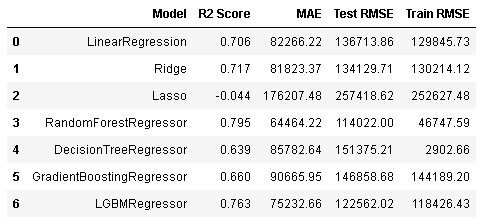

## Second method (filling Na values with zero)

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgbm

#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    #transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, y_train)
    yhat = regr_trans.predict(X_test)
    train_pred = regr_trans.predict(X_train)
    algoname= x.__class__.__name__
    return algoname, round(r2_score(y_test, yhat),3), round(mean_absolute_error(y_test, yhat),2), round(metrics.mean_squared_error(y_test, yhat, squared=False),2), round(metrics.mean_squared_error(y_train, train_pred, squared=False),2)

algo=[LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(), DecisionTreeRegressor(), GradientBoostingRegressor(), lgbm.LGBMRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))

#Collate all scores in a table
pd.DataFrame(score, columns=['Model', 'R2 Score', 'MAE', 'Test RMSE', 'Train RMSE'])

,Model,R2 Score,MAE,Test RMSE,Train RMSE
0,LinearRegression,0.585,70925.58,122260.31,97449.83
1,Ridge,0.712,67331.93,101795.40,97896.90
2,Lasso,-0.054,138378.51,194804.30,199778.59
3,RandomForestRegressor,0.750,58982.55,94889.25,36939.50
4,DecisionTreeRegressor,0.558,78454.15,126130.68,2439.26
5,GradientBoostingRegressor,0.623,77866.10,116513.10,115092.18
6,LGBMRegressor,0.725,66064.57,99573.42,95745.98


**Once Na values are filled with zero and the data frame is expanded with is_na columns, there is a big improvement in Root Mean Squared Error value and the best model for this problem seems like the Random Forest model**